## Imports and creds

In [4]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

In [5]:
import numpy as np

In [6]:
import sys
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model

In [7]:
# Mount drive - needed for GBQ creds
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
root_path = '/content/drive/MyDrive/GitHub'

In [9]:
credentials = service_account.Credentials.from_service_account_file(
    f'{root_path}/grav-waves/grav-waves-358320-34ebfeae2689.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [10]:
# This needs to be run to assign from BQ magic directly to pd df; otherwise, can use the string alternative
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Aesthetic settings

In [11]:
%load_ext rpy2.ipython

In [ ]:
%%R
# Libraries
install.packages("sysfonts")
install.packages("extrafont")
install.packages("showtext")
install.packages("bigrquery")
library(sysfonts)
library(extrafont)
library(showtext)
library(bigrquery)
library(tidyverse)
library(glue)

showtext_auto()
font_add_google("Inter", "int")

# Create a theme
theme_light_beige <- theme(plot.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      panel.background = element_rect(fill = "#F0F1EA", color = "transparent"),
      plot.margin = margin(t = "1.5", r = "1.5", b = "1.5", l = "1.5", unit = "in"),
      plot.caption = element_text(size = 12, color = "#343A41", family = "int"),
      panel.grid = element_blank(),
      plot.title = element_text(size = 30, color = "#343A41", family = "int", face = "bold"),
      axis.text = element_text(size = 15, color = "#343A41", family = "int"),
      axis.title = element_text(size = 19, color = "#343A41", family = "int"),
      axis.ticks = element_blank(),
      legend.background = element_blank(),
      legend.position = "bottom",
      legend.title = element_text(color = "#343A41", family = "int"),
      legend.text = element_text(color = "#343A41", family = "int"),
      strip.background = element_rect(fill = "#343A41"),
      strip.text = element_text(color = "white", family = "int", face = "bold", size = 13))

## Pre-processing

All pre-processing hasn't been completed, but that can easily be configured later. We'll want to match pre-processing to exactly what's done in practice when the interferometer data is streaming in. For now, I'll use the raw timeseries data to model, which should be enough at least to get the architecture tested.

In [1]:
%%bigquery --project grav-waves-358320 gw322

SELECT capture_dttm, size, (size - LAG(size) OVER(PARTITION BY id ORDER BY capture_dttm)) / LAG(size) OVER(PARTITION BY id ORDER BY capture_dttm) AS pct_chg
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
;

In [2]:
gw322

,capture_dttm,size,pct_chg
0,2020-03-22 09:11:18.300244,1.849810e-19,0.081729
1,2020-03-22 09:11:18.300488,1.983925e-19,0.072503
2,2020-03-22 09:11:18.300732,2.127022e-19,0.072128
3,2020-03-22 09:11:18.300977,2.272327e-19,0.068314
4,2020-03-22 09:11:18.301221,2.411845e-19,0.061399


In [44]:
len(gw322)

122879

Let me do a quick visual check of the data.

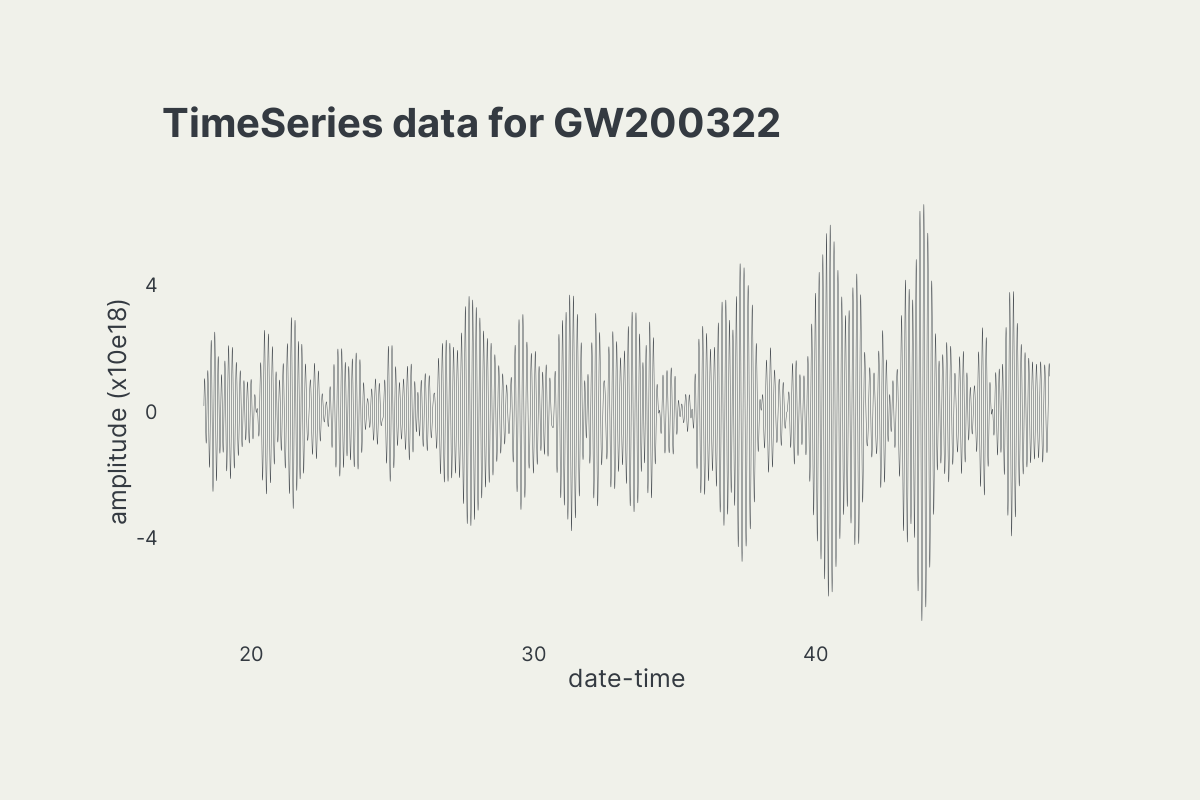

In [31]:
%%R -w 1200 -h 800 -i gw322

ggplot(gw322, aes(capture_dttm, size*1e18)) +
geom_line(color = "#343A41", size = 0.2) +
labs(x = 'date-time',
     y = 'amplitude (x10e18)',
     title = 'TimeSeries data for GW200322\n') +
theme_light_beige

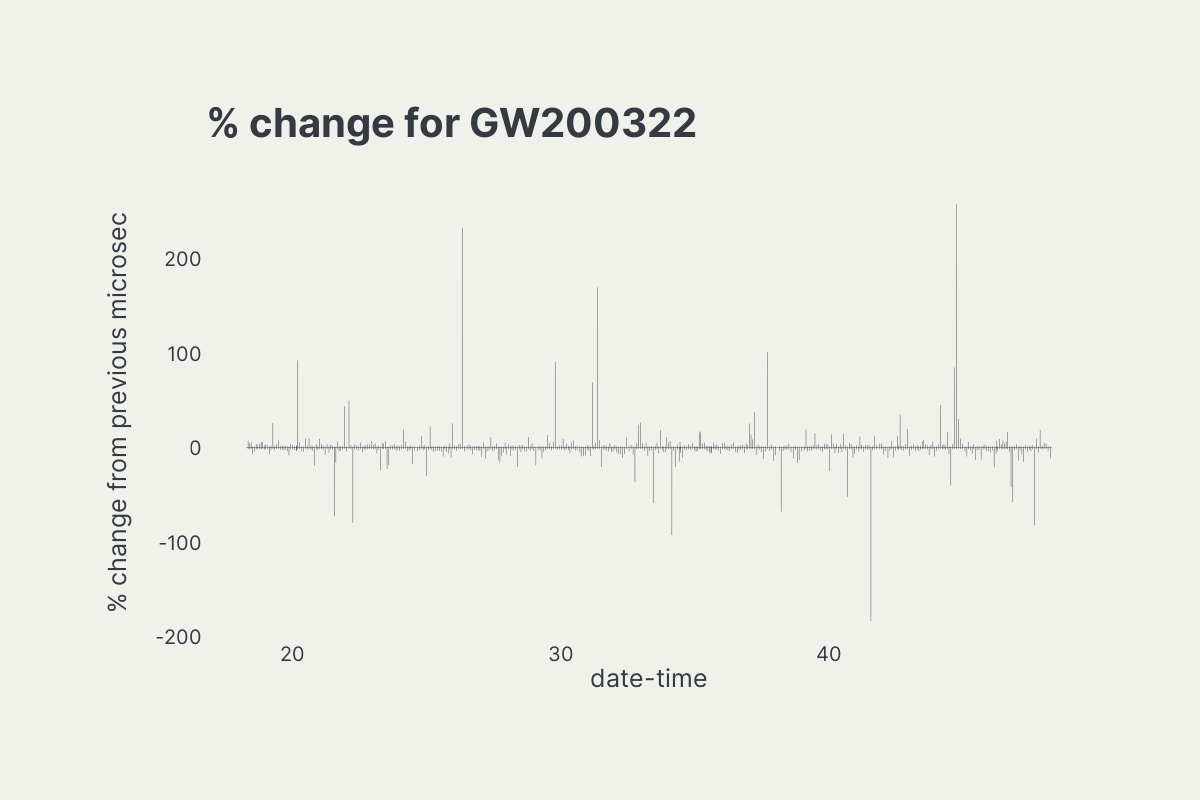

In [30]:
%%R -w 1200 -h 800

ggplot(gw322, aes(capture_dttm, pct_chg)) +
geom_line(color = "#343A41", size = 0.2) +
labs(x = 'date-time',
     y = '% change from previous microsec\n',
     title = '% change for GW200322\n') +
theme_light_beige

Ok, everything looks as expected at the microsecond level. Now, to narrow the dataset to a reasonable size for this standalone analysis, let's first see what the average value by millisecond looks like.

In [1]:
%%bigquery --project grav-waves-358320 gw322_ms

SELECT DATE_TRUNC(capture_dttm, MILLISECOND) AS capture_ms, AVG(size) AS avg_size
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1
;

In [17]:
len(gw322_ms)

30001

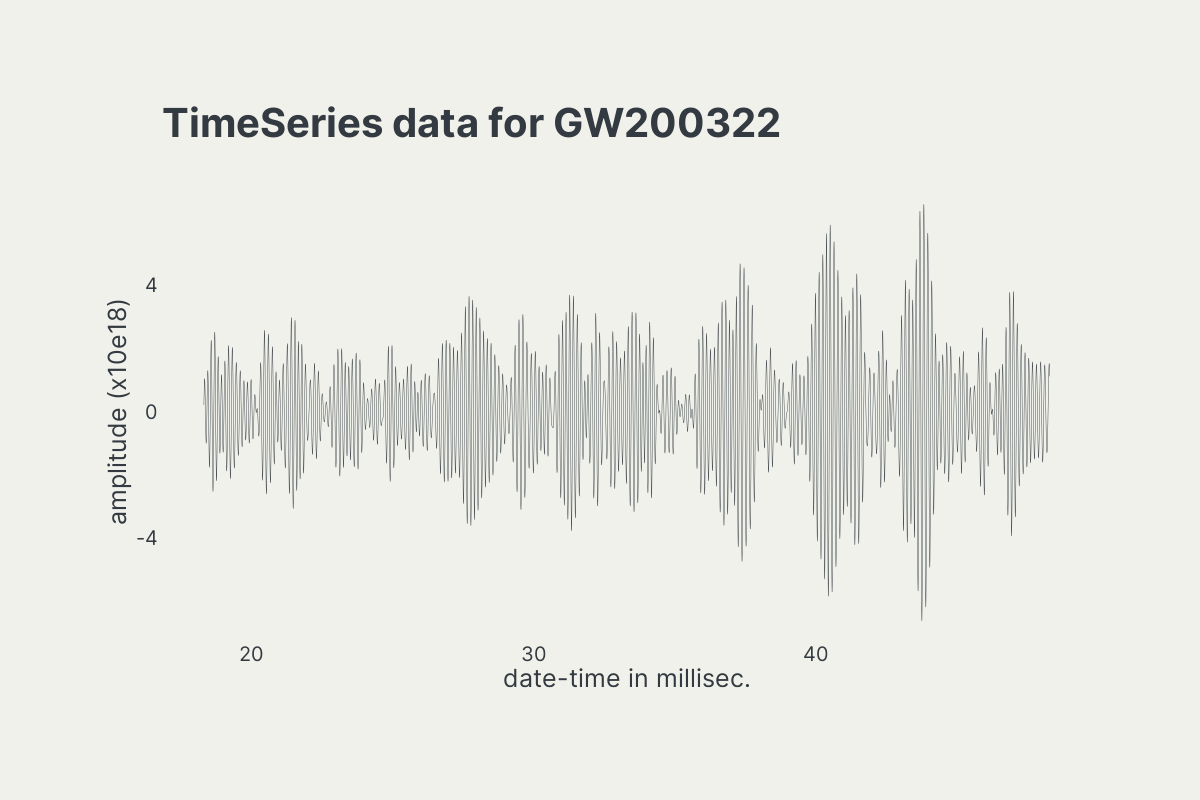

In [6]:
%%R -w 1200 -h 800 -i gw322_ms

ggplot(gw322_ms, aes(capture_ms, avg_size*1e18)) +
geom_line(color = "#343A41", size = 0.2) +
labs(x = 'date-time in millisec.',
     y = 'amplitude (x10e18)',
     title = 'TimeSeries data for GW200322\n') +
theme_light_beige

I think we could go even less granular. Let me try averaging at the seconds-level.

In [7]:
%%bigquery --project grav-waves-358320 gw322_sec

SELECT DATE_TRUNC(capture_dttm, SECOND) AS capture_sec, AVG(size) AS avg_size
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1
;

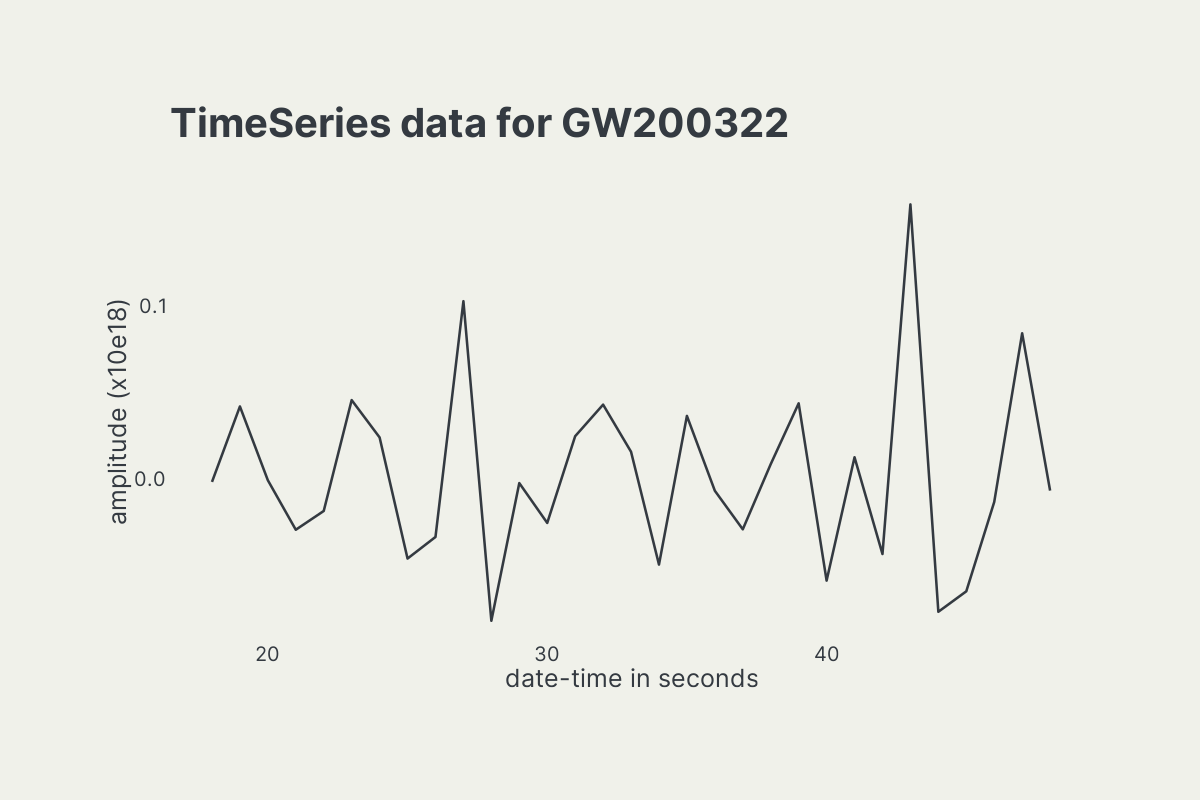

In [10]:
%%R -w 1200 -h 800 -i gw322_sec

ggplot(gw322_sec, aes(capture_sec, avg_size*1e18)) +
geom_line(color = "#343A41", size = 1.2) +
labs(x = 'date-time in seconds',
     y = 'amplitude (x10e18)',
     title = 'TimeSeries data for GW200322\n') +
theme_light_beige

Wow. That definitely lacks a lot of detail but still appears to contain the signal. What about centiseconds or deciseconds?

In [18]:
%%bigquery --project grav-waves-358320 gw322_csec

SELECT CONCAT(DATE_TRUNC(capture_dttm, SECOND), ROUND(EXTRACT(MILLISECOND FROM capture_dttm)/100, 1)*10) AS capture_csec, AVG(size) as av_size
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1;

In [10]:
%%bigquery --project grav-waves-358320 gw322_dsec

SELECT CONCAT(DATE_TRUNC(capture_dttm, SECOND), ROUND(EXTRACT(MILLISECOND FROM capture_dttm)/100)) AS capture_dsec, AVG(size) as av_size
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1;

In [21]:
len(gw322_dsec)

331

In [24]:
gw322_dsec

,capture_dsec,av_size
0,2020-03-22 09:11:183,7.375427e-19
1,2020-03-22 09:11:184,3.679296e-20
2,2020-03-22 09:11:185,-3.574173e-19
3,2020-03-22 09:11:186,-3.548384e-19
4,2020-03-22 09:11:187,5.081694e-19
...,...,...
326,2020-03-22 09:11:4710,1.271010e-18
327,2020-03-22 09:11:480,-5.811610e-19
328,2020-03-22 09:11:481,2.785329e-19
329,2020-03-22 09:11:482,-6.131062e-19


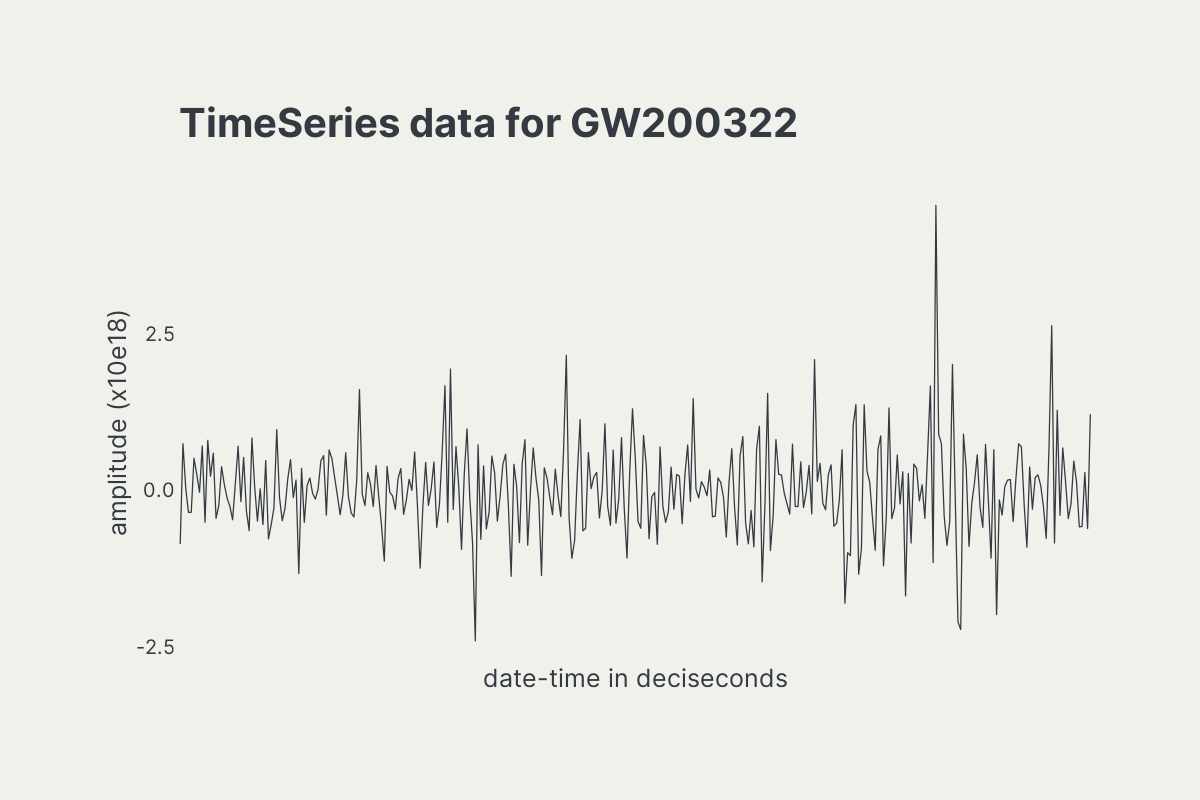

In [29]:
%%R -w 1200 -h 800 -i gw322_dsec

ggplot(gw322_dsec, aes(capture_dsec, av_size*1e18, group = 1)) +
geom_line(color = "#343A41", size = 0.6) +
labs(x = 'date-time in deciseconds',
     y = 'amplitude (x10e18)',
     title = 'TimeSeries data for GW200322\n') +
theme_light_beige +
theme(axis.text.x = element_blank())

Ok, this looks like the right level of granularity. It preserves the signal without being overly reductive. Now let's get the percent-change from previous decisecond and normalize.

In [13]:
%%bigquery --project grav-waves-358320 gw322_dsec

WITH dsec_sz AS (SELECT CONCAT(DATE_TRUNC(capture_dttm, SECOND), ROUND(EXTRACT(MILLISECOND FROM capture_dttm)/100)) AS capture_dsec, AVG(size) as av_size
FROM mergers.timeseries
WHERE id = 'GW200322_091133-v1'
AND observatory = 'L1' --start w/ the L1 interferometer
GROUP BY 1)

SELECT capture_dsec, (av_size - LAG(av_size) OVER(ORDER BY capture_dsec)) / LAG(av_size) OVER(ORDER BY capture_dsec) AS pct_chg
FROM dsec_sz;

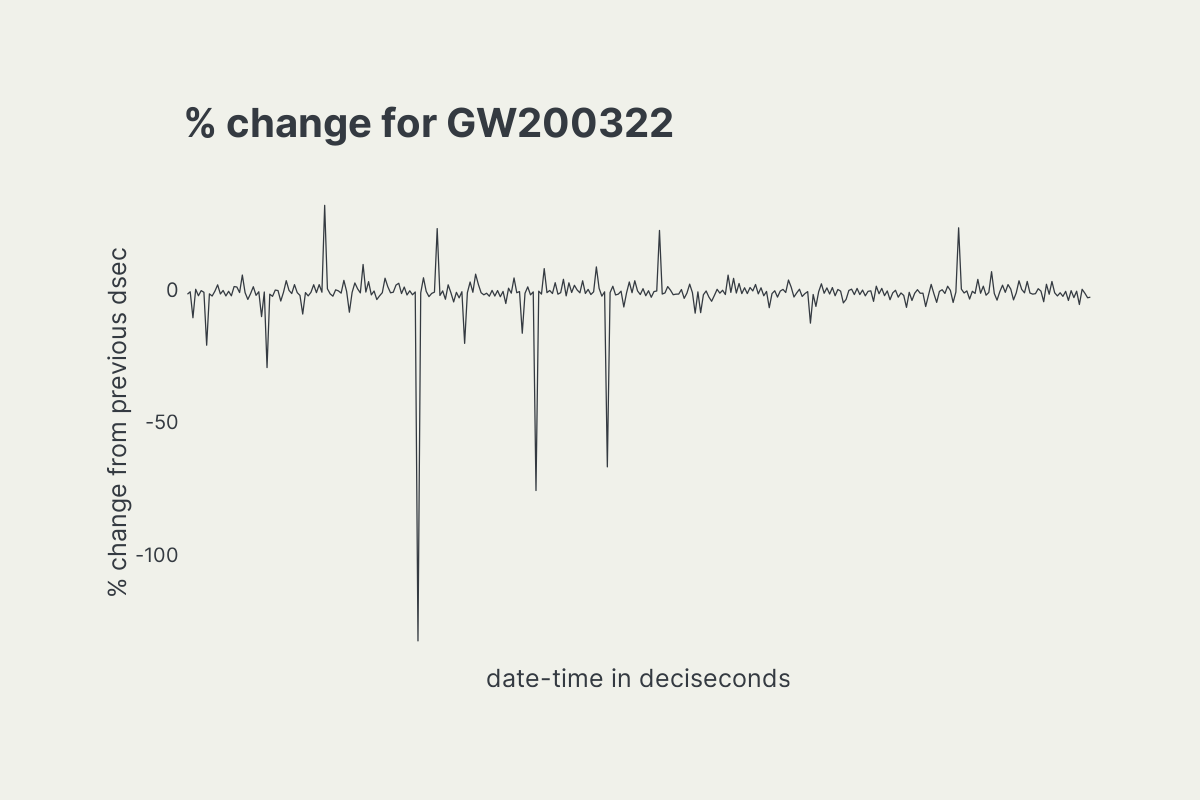

In [38]:
%%R -w 1200 -h 800 -i gw322_dsec

ggplot(gw322_dsec, aes(capture_dsec, pct_chg, group = 1)) +
geom_line(color = "#343A41", size = 0.6) +
labs(x = 'date-time in deciseconds',
     y = '% change from previous dsec',
     title = '% change for GW200322\n') +
theme_light_beige +
theme(axis.text.x = element_blank())

In [14]:
pc_norm = (gw322_dsec['pct_chg'].dropna() - gw322_dsec['pct_chg'].dropna().mean()) / gw322_dsec['pct_chg'].dropna().std()

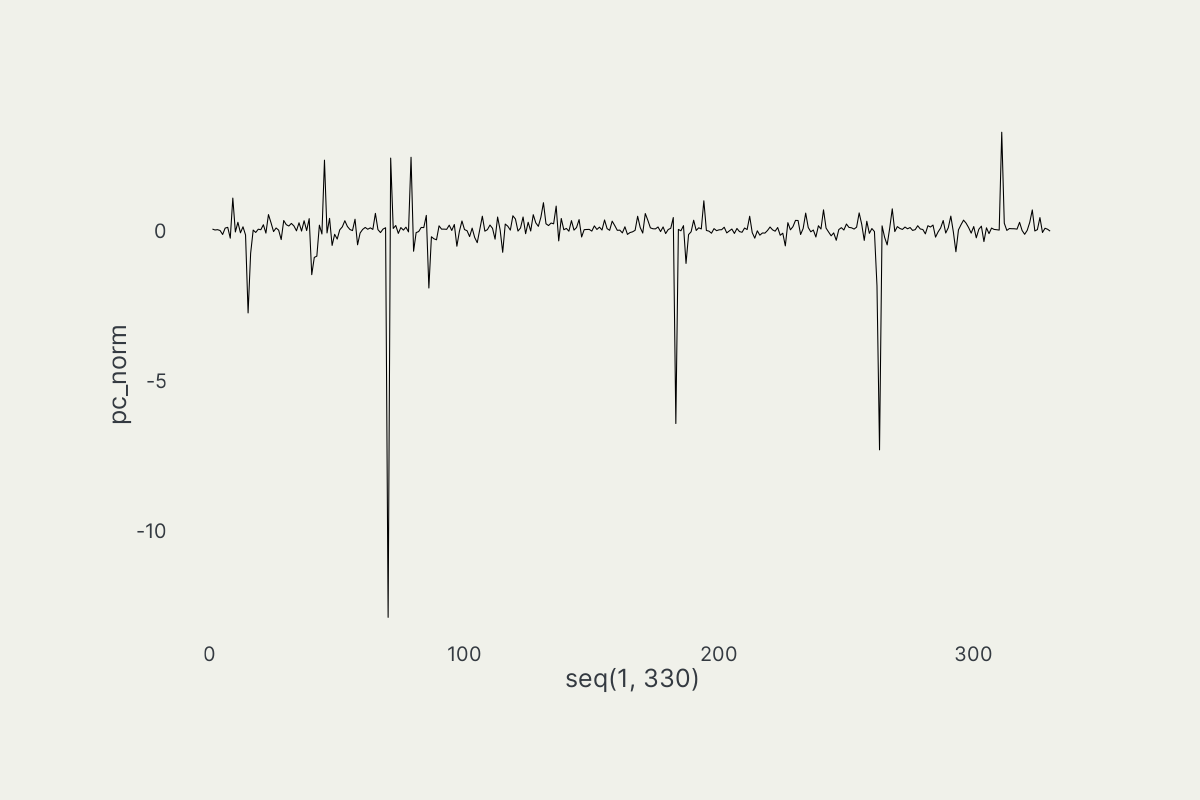

In [150]:
%%R -w 1200 -h 800 -i pc_norm

ggplot() +
aes(seq(1, 330), pc_norm) +
geom_line() +
theme_light_beige

In [13]:
np.mean(np.array(pc_norm)), np.std(np.array(pc_norm)) # essentially 1, 0

(-5.382899513334092e-18, 0.9984836989003361)

In [15]:
pc_norm

0      0.065725
1      0.034938
2      0.045201
3      0.017493
4     -0.115034
         ...   
326    0.448266
327   -0.048684
328    0.092988
329    0.059445
330   -0.003314
Name: pct_chg, Length: 330, dtype: float64

## Modeling

### Naive estimator

### ARIMA

In [2]:
import statsmodels.api as sm

In [3]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
len(pc_norm)

330

In [18]:
arima_mod = ARIMA(pc_norm, order=(1,1,1))
arima_model = arima_mod.fit()
forecast = arima_model.predict(start = 264, end = 330, dynamic = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

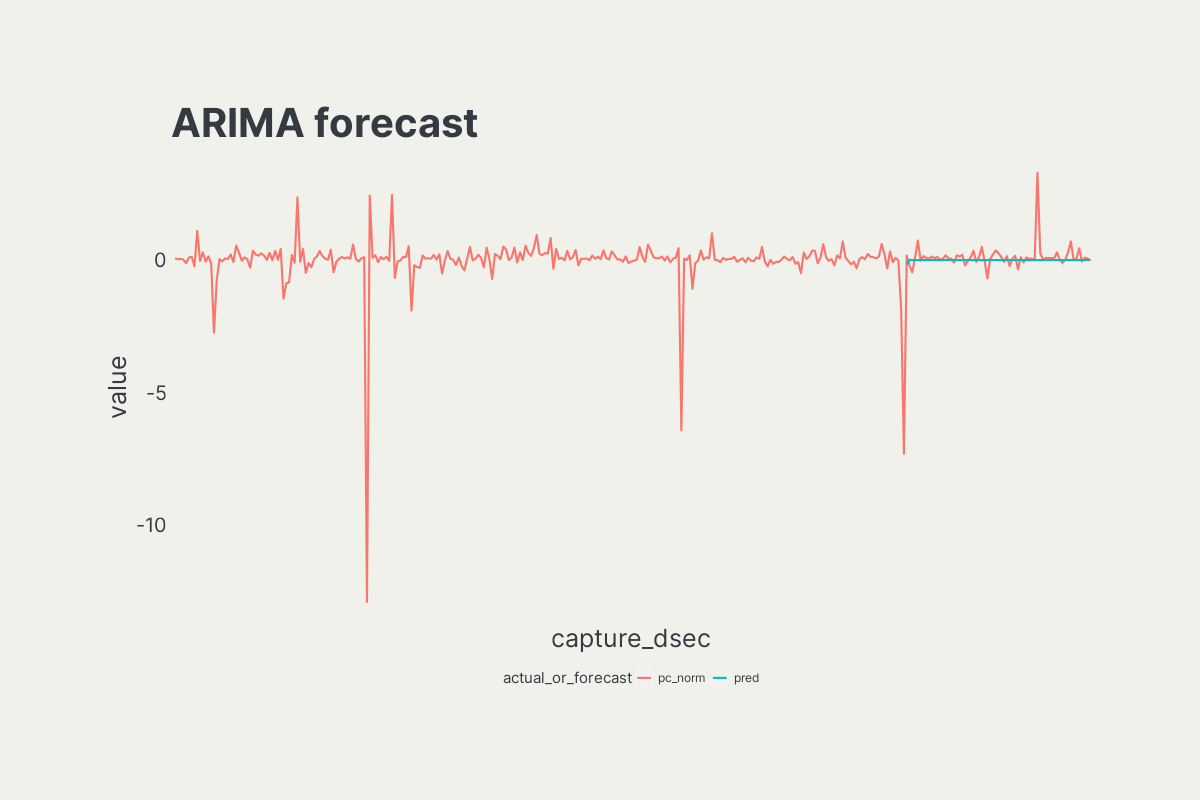

In [41]:
%%R -i gw322_dsec -i pc_norm -i forecast -w 1200 -h 800

gw322_dsec %>%
  arrange(capture_dsec) %>%
  mutate(pc_norm = c(NA,pc_norm)) %>%
  add_column(pred = c(rep(NA, 264), forecast)) %>%
  gather(pred, pc_norm, key = "actual_or_forecast", value = "value") %>%
  # filter(!is.na(pred)) %>%
  ggplot(aes(capture_dsec, value, group = actual_or_forecast, color = actual_or_forecast)) +
  geom_line(size = 1) +
  labs(title = "ARIMA forecast") +
  theme_light_beige +
  theme(axis.text.x = element_blank())

Well that looks terrible. But intuitively, it makes sense that that's the case since there's not really any seasonality or underlying periodicity to the data for the ARIMA model to go off of.

### LSTM

In [ ]:
tf.random.set_seed(seed = 23)

In [18]:
def generate_windows(data, look_back):

  target = np.asarray(data)
  target = np.atleast_2d(target)
  
  if target.shape[0] == 1:
    target = target.T
    
  X = np.atleast_3d(np.array([target[start:start + look_back] for start in range(0, target.shape[0] - look_back)]))
  
  y = target[look_back:]
  
  return X, y

In [19]:
X, y = generate_windows(pc_norm, look_back = round(len(pc_norm)*0.8))

In [155]:
X.shape, y.shape

((66, 264, 1), (66, 1))

In [17]:
model = Sequential()

model.add(Input(shape = (264,1)))
model.add(LSTM(330, return_sequences = True, activation = 'tanh'))
model.add(LSTM(264, return_sequences = False, activation = 'relu'))
model.add(Dense(1))
model.add(Activation(activation = 'linear'))

model.compile(optimizer="rmsprop", loss = "mae")

In [162]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 264, 330)          438240    
                                                                 
 lstm_3 (LSTM)               (None, 264)               628320    
                                                                 
 dense_1 (Dense)             (None, 1)                 265       
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 1,066,825
Trainable params: 1,066,825
Non-trainable params: 0
_________________________________________________________________


#### LSTM Training

In [163]:
model.fit(X, y, epochs = 10, batch_size = 80, verbose = 1, shuffle = False)

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.2063
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.2237
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.2025
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.1877
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.1863
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.1868
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.1880
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.1850
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.1841
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: 0.1822


In [ ]:
in_sample_predictions = model.predict(X)

In [168]:
in_sample_predictions[0][0], X[0][0]

(-0.16390796, array([0.06572521]))

In [170]:
preds = in_sample_predictions.flatten()

In [172]:
preds.shape

(66,)

In [174]:
preds

array([-0.16390796, -0.08813753, -0.01478393,  0.04603817,  0.08270235,
        0.09676107,  0.09969795,  0.09611692,  0.0895396 ,  0.0822923 ,
        0.0749882 ,  0.06856755,  0.06314012,  0.0588994 ,  0.05565574,
        0.05304066,  0.05104353,  0.04966058,  0.04878085,  0.0479506 ,
        0.04708289,  0.04634493,  0.04610247,  0.04600134,  0.04575397,
        0.0451015 ,  0.0445594 ,  0.04418304,  0.0430679 ,  0.03801434,
        0.03967454,  0.04185537,  0.04318303,  0.04348698,  0.04303123,
        0.04236056,  0.04195416,  0.04189298,  0.0422113 ,  0.04249667,
        0.0421388 ,  0.04280306,  0.0431499 ,  0.04363263,  0.04389574,
        0.04395168,  0.04385942,  0.05362128,  0.05238714,  0.04852512,
        0.04503803,  0.04259619,  0.04116035,  0.04046465,  0.0402908 ,
        0.04029941,  0.04086075,  0.04173031,  0.04210579,  0.04269218,
        0.04174157,  0.04082298,  0.04047441,  0.03968355,  0.03927278,
        0.03914645], dtype=float32)

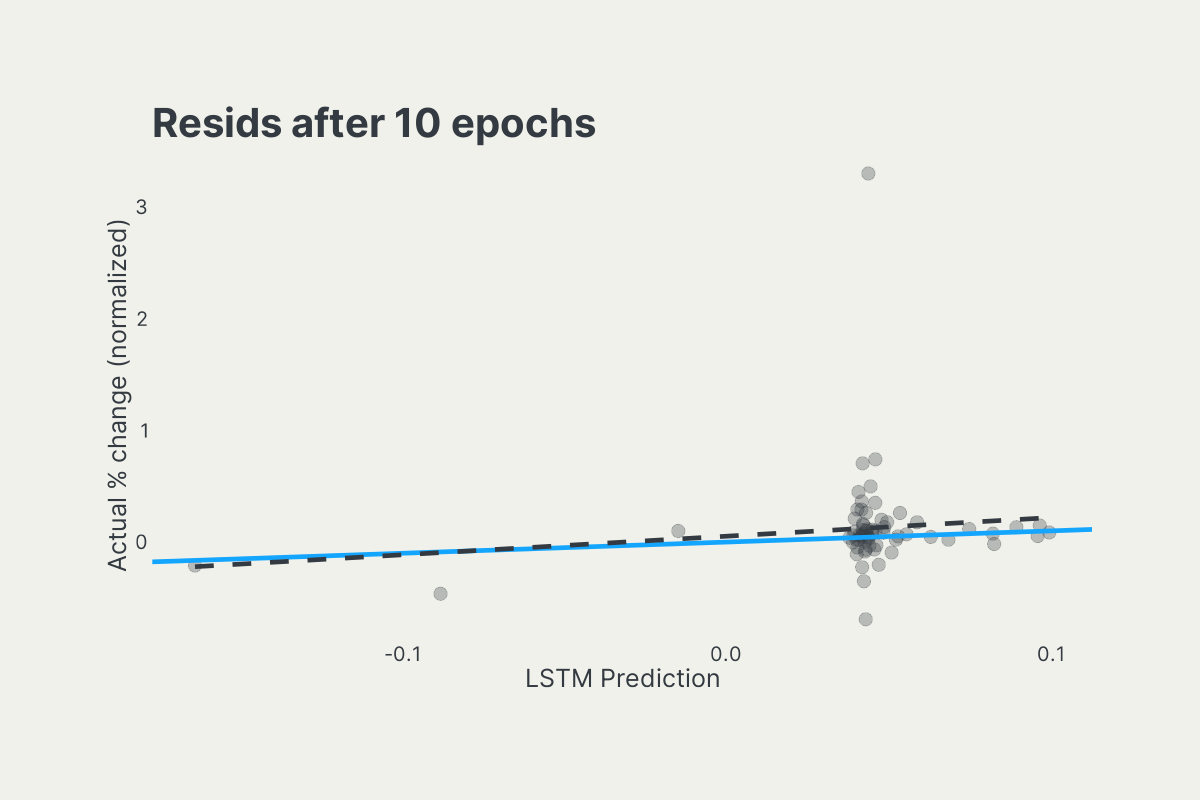

In [212]:
%%R -w 1200 -h 800

data.frame(pc_norm = pc_norm) %>%
  add_column(pred = c(rep(NA, 264), preds)) %>%
  filter(!is.na(pred)) %>%
  ggplot(aes(pred, pc_norm)) +
  geom_point(alpha = 0.3, color = "#343A41", size = 6) +
  geom_abline(slope = 1, size = 2.2, color = "#14A5FF") +
  geom_smooth(method = "lm", se = FALSE, color = "#343A41", linetype = "dashed", size = 2.2) +
  labs(x = "LSTM Prediction",
       y = "Actual % change (normalized)",
       title = "Resids after 10 epochs") +
  theme_light_beige

In [216]:
model.fit(X, y, epochs = 1000, batch_size = 80, verbose = 1, shuffle = False)

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1827
Epoch 2/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1803
Epoch 3/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1823
Epoch 4/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1828
Epoch 5/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1873
Epoch 6/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1814
Epoch 7/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1799
Epoch 8/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1798
Epoch 9/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1816
Epoch 10/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1803
Epoch 11/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1803
Epoch 12/1000
1/1 [==============================] - 4s 4s/step - loss: 0.1816
Epoch 13/1000
1/1 [==============================] - 4s 4s/st

KeyboardInterrupt: ignored

Looked like the loss was just bouncing around there a bit. Let's try 20 epochs with smaller batches.

In [20]:
model.fit(X, y, epochs = 20, batch_size = 40, verbose = 1, shuffle = False)

Epoch 1/20
2/2 [==============================] - 9s 2s/step - loss: 0.1998
Epoch 2/20
2/2 [==============================] - 5s 2s/step - loss: 0.2474
Epoch 3/20
2/2 [==============================] - 5s 2s/step - loss: 0.1936
Epoch 4/20
2/2 [==============================] - 5s 2s/step - loss: 0.1859
Epoch 5/20
2/2 [==============================] - 5s 2s/step - loss: 0.1845
Epoch 6/20
2/2 [==============================] - 5s 2s/step - loss: 0.1841
Epoch 7/20
2/2 [==============================] - 5s 2s/step - loss: 0.1888
Epoch 8/20
2/2 [==============================] - 5s 2s/step - loss: 0.1871
Epoch 9/20
2/2 [==============================] - 5s 2s/step - loss: 0.1850
Epoch 10/20
2/2 [==============================] - 5s 2s/step - loss: 0.1815
Epoch 11/20
2/2 [==============================] - 5s 2s/step - loss: 0.1807
Epoch 12/20
2/2 [==============================] - 5s 2s/step - loss: 0.1819
Epoch 13/20
2/2 [==============================] - 5s 2s/step - loss: 0.1794
Epoch 14

In [22]:
model.save("/content/drive/MyDrive/GitHub/grav-waves/models/gw_lstm1")

Still bouncy but will focus on tuning the hyperparameters in a bit.

In [218]:
preds2 = model.predict(X)

In [219]:
preds2_flat = preds2.flatten()

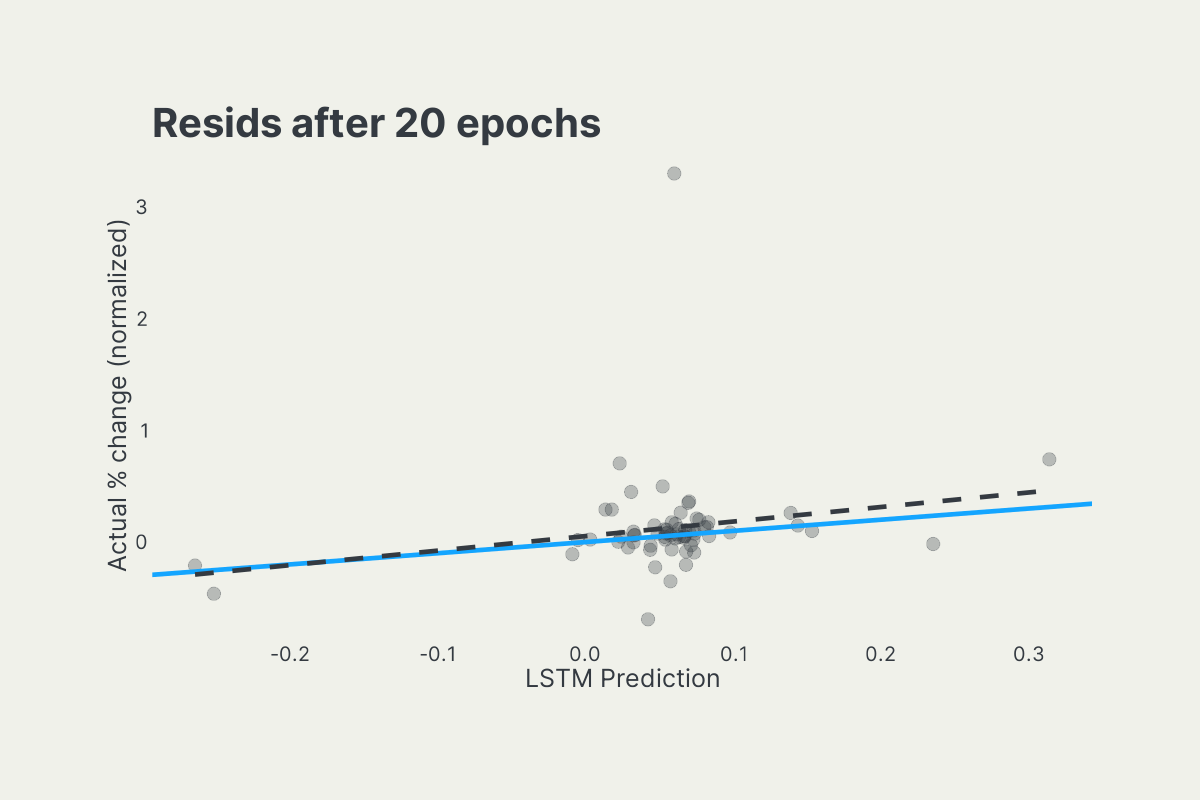

In [220]:
%%R -w 1200 -h 800 -i preds2_flat

data.frame(pc_norm = pc_norm) %>%
  add_column(pred = c(rep(NA, 264), preds2_flat)) %>%
  filter(!is.na(pred)) %>%
  ggplot(aes(pred, pc_norm)) +
  geom_point(alpha = 0.3, color = "#343A41", size = 6) +
  geom_abline(slope = 1, size = 2.2, color = "#14A5FF") +
  geom_smooth(method = "lm", se = FALSE, color = "#343A41", linetype = "dashed", size = 2.2) +
  labs(x = "LSTM Prediction",
       y = "Actual % change (normalized)",
       title = "Resids after 20 epochs") +
  theme_light_beige

In [ ]:
model.fit(X, y, epochs = 20, batch_size = 40, verbose = 1, shuffle = False)